<h1> MPH Thesis Scribbles </h1>
<h2> The Beginning </h2>

---

I've been spending a lot of time thinking about potential thesis projects for my MPH. I am currently in my second-to-last semester, and I'm hoping to get a headstart on my capstone with my coursework for my advanced biostats course and my public health research methods course. 

I am considering doing another disease incidence modeling project. I have some experience building predictive models for Lyme Disease, using climatic variables as parameters. My applied practice experience increased my interest in applied public health practice at the state and local level, however, so I don't want to do another ecological study like the Lyme project. 

So, I'm interested in creating a model to forecast and nowcast respiratory disease incidence in Kent County. I want to explore the impact of weather and climate on respiratory diseases, and I also want to include other parameters associated with respiratory disease increasing in the community. 

As a particular example, I want to explore the relationship between Google search queries and respiratory disease. I hypothesize that search terms related to cold&flu symptoms should spike 1-2 weeks before ILI incidence spikes. To explore my hypothesis, I will do some exploratory data analysis and visualization

This tutorial uses Pytrends to exploit Google Trends search term data from within the Grand Rapids metro area. I will leverage this data alongside my already existing Kent County ILI incidence data from my practicum to examine the relations between specific search terms and ILI incidence

---

This tutorial leverages the python module Pytrends to fetch Google search term history in the Grand Rapids metro area. Pytrends is a 'psuedo-API' for the Google Trends project, and there is a significant learning curve for API calling. Go [here](https://lazarinastoy.com/the-ultimate-guide-to-pytrends-google-trends-api-with-python/) to learn more about Pytrends and how to use it

Let's get started by importing the modules we will be using.

In [1]:
import pandas as pd
from pytrends.request import TrendReq
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np

pytrends = TrendReq(hl='en-US', tz=360)

To call the Google Trends API, we must give Google information about which search term history we want, from which time period, and from where. Specifying location and timeframe is vital for the reliability of the data because Google normalizes and scales the data based on population size. 

Our specified search terms, location, and time period will be the 'payload' of our data request. To build the payload effectively, we must specify these terms in a format that Google will understand.

Google expects to see the 2-character alpha geocode for both country and state; US-MI. To drill down to the city level we use DMA codes. The DMA code for Grand Rapids-Kalamazoo-Battle Creek is 563, so altogether, the location code is geo = US-MI-563

In [2]:
geo = 'US-MI-563'

There are a few ways to specify your timeframe of interest. The default is the last 5 years, 'today 5-y', following the Current Time Minus Time Pattern. To specify by month, 'today #-m', by day, 'today #-d', and by hour, 'today #-h'

Another option is to specify a date range in the format 'yyyy-mm-dd yyy-mm-dd'

To see ten years of data, we will specify timeframe = '2012-01-01 2023-07-01'

In [3]:
timeframe = '2012-01-01 2023-07-01'

Optionally, we may specify a search term category to narrow our results. The default category cat = 0, and the rest of the category codes can be found [here](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)

The category code for 'Health Conditions' is cat = 419

In [4]:
cat = 419

Unfortunately, Google limits the number of search terms we may include in our request to 5. We are interested in terms related to respiratory illness, so we will check the following:

In [5]:
kwords = [
          #'flu',
          #'fever',
          #'sore throat',
            'cough',
            'cold',
          #'symptoms',
          #'chills',
          ]

Now we're ready to build our request payload. We'll do the request, then save its output into a dataframe

In [6]:
pytrends.build_payload(kwords, cat=cat, timeframe=timeframe, geo=geo)
data = pytrends.interest_over_time().reset_index().rename(columns={'date':'Date'})

Next we extract and preprocess Kent County Influenza-Like Illness incidence data. We use sklearn's StandardScaler to center each variable around their respective means, then combine all variables into a single dataframe. 

In [7]:
dd = pd.read_csv("C:\\Users\\ljens\\OneDrive\\Documents\\MSU MPH\\Practicum\\older dates\\data.csv")
flu = dd.loc[dd['Disease Group'] == 'InfluenzaInfluenzaInfluenzaInfluenza']
flu = flu[['Time','Count']]
flu['Time'] = pd.to_datetime(flu['Time'])
flu['Count'] = flu['Count'].astype('int')
flu['flu'] = StandardScaler().fit(np.array(flu['Count']).reshape(-1,1)).transform(np.array(flu['Count']).reshape(-1,1))
flu.rename(columns={'Time':'Date'},inplace=True)
flu.set_index('Date',inplace=True)
flu = flu.drop(columns=['Count'])

In [8]:
df = pd.DataFrame()
df['Date'] = data['Date']
df['cough'] = StandardScaler().fit(np.array(data['cough']).reshape(-1,1)).transform(np.array(data['cough']).reshape(-1,1))
df['cold'] = StandardScaler().fit(np.array(data['cold']).reshape(-1,1)).transform(np.array(data['cold']).reshape(-1,1))
df = df.set_index('Date').join(flu).reset_index()

Let's take a look at our data so far

In [9]:
df.head()

,Date,cough,cold,flu
0,2012-01-01,-0.631781,0.011697,1.209774
1,2012-02-01,-0.573469,-0.300974,1.369333
2,2012-03-01,-0.690093,-0.863781,2.298753
3,2012-04-01,-0.631781,-0.738713,0.542561
4,2012-05-01,-0.398534,-0.738713,0.106480


So far, so good. To explore and compare our variables, we want to create a line graph with each variable as a unique series. But first, we must transform the data into long-form by unpivoting the dataframe. Fortunately, pandas' melt() method makes pivoting and unpivoting data super easy.

In [10]:
df = pd.melt(df, id_vars='Date', value_vars=['cough','cold','flu'], value_name='Normalized Hits',var_name='Variables')

In [11]:
df.head()

,Date,Variables,Normalized Hits
0,2012-01-01,cough,-0.631781
1,2012-02-01,cough,-0.573469
2,2012-03-01,cough,-0.690093
3,2012-04-01,cough,-0.631781
4,2012-05-01,cough,-0.398534


Last but not least, let's plot our data

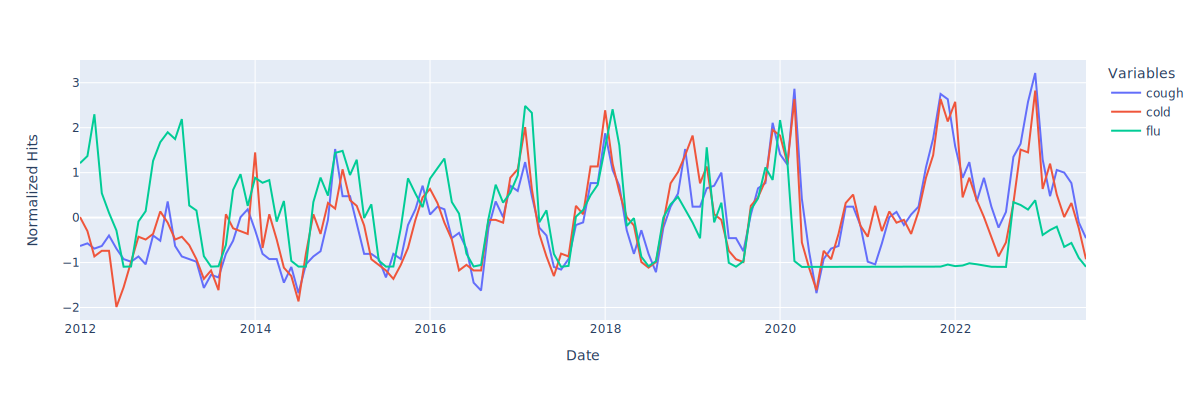

In [19]:
fig = px.line(df, x='Date',y='Normalized Hits',color='Variables', width=1200, height=400)
fig.show('svg')

There's a few things to note before we try to make any inferences from this graph. ILI went under-reported during the beginning stages of COVID - this is seen with the flatline on the right. These will pull the mean ILI incidence downward; t. hey should really be censured entirely. 

Additionally, flu spikes in 2013 and 2018, likely due to H1N1 epidemics. I don't suspect that these spikes will have a detrimental skewing effect on flu data.

Lastly, the rise and fall of google searches for 'cough' and/or 'cold' seems be be growing over time. This might be a result of increasing internet us over time.

With these points in mind, it doesn't seem that the google searches are preceeding spikes in flu incidence. It might be that they truly have no predictive value for flu, or perhaps the rate of change in google searches would be better predictors of impending flu spikes. More analysis is required. 